In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def generate_time_series(num_timeseries, n_steps):
    
    freq1, freq2, phase1, phase2 = np.random.rand(4, num_timeseries, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time-phase1) * (freq1 * 10 + 10)) # First sine wave
    series += 0.2 * np.sin((time-phase2) * (freq2 * 20 + 20)) # Second sine wave
    series += 0.1 * (np.random.rand(num_timeseries, n_steps) - 0.5) # Noise
    
    # return a 3 dimensional series [num_timeseries, n_steps, 1]
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# Let's generate 10000 time series of 50 steps in order to predict one step ahead.
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

In [4]:
# X_train contains 7000 time series of shape (50,1) therefore X_train is [7000, 50, 1]
# y_train takes the last element of each series as a label
X_train, y_train = series[:7000, :n_steps ], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
print(X_train.shape)
print(y_train.shape)

(7000, 50, 1)
(7000, 1)


# Simple RNN

In [6]:
# input_shape is [None, 1] because a RNN model can process sequences of any length, and this is univariate time series.
# Also we will use the simplest architecture: a single layer with 1 neuron.
simple_rnn = keras.Sequential([
    layers.SimpleRNN(1, input_shape=[None, 1])
])
simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


For each neuron, there is one parameter per input and per hidden step dimension (in this case it is the number of neurons in the layer), plus a bias term. That's just 3 parameters.

In [7]:
optimizer = keras.optimizers.Adam(lr=0.01)
simple_rnn.compile(loss="mse", optimizer=optimizer)

By default the SimpleRNN uses a tanh activation function. The initial state is set to 0 and it is passed to a single recurrent neuron along with the value of the first time step x(0). The neuron computes a weighted sum of these values, applies tanh to the result and gives the result to the new state that is passed again to the same recurrent neuron along with x(1) for processing repeatedly until last time step until the layer just outputs the last value y49. This is done simultaneously for every time series

In [8]:
# Our model will train on batches of 32 x 219x50x1. 
history = simple_rnn.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.1019 - val_loss: 0.0136
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0119
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0119
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0113 - val_loss: 0.0119
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0116 - val_loss: 0.0118

In [9]:
simple_rnn.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0117


0.011671039275825024

# Deep RNN

In [10]:
# This model will output one predicted value, therefore Dense(1)
# input_shape= [batch_size, series length, series dimension], here batch size is unspecified -> default to 32

deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.Dense(1)
])

In [11]:
deep_rnn.compile(loss="mse", optimizer=optimizer)

In [12]:
history = deep_rnn.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 19ms/step - loss: 0.2602 - val_loss: 0.1454
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.1535 - val_loss: 0.1458
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.1566 - val_loss: 0.1453
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.1518 - val_loss: 0.1447
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.1498 - val_loss: 0.1456
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.1503 - val_loss: 0.1472
Epoch 7/20
219/219 [==============================] - 5s 24ms/step - loss: 0.1537 - val_loss: 0.1454
Epoch 8/20
219/219 [==============================] - 4s 18ms/step - loss: 0.1491 - val_loss: 0.1452
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.1471 - val_loss: 0.1437
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.1460 - val_lo

In [13]:
deep_rnn.evaluate(X_test, y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.1454


0.14544939994812012

# Forecasting the next 10 steps

We will train a sequence-to-vector RNN to predict all 10 next values at once. The targets will contain the next 10 values. 

In [14]:
series = generate_time_series(10000, n_steps + 10)

In [15]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [16]:
print(X_train.shape)
print(y_train.shape)

(7000, 50, 1)
(7000, 10)


In [17]:
# Our model has 3 layers, inputs a univariate series of any length and outputs a 10 value vector.
# input_shape= [batch_size, series length, series dimension], here batch size is unspecified -> default to 32

model = keras.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), 
    keras.layers.Dense(10)
])

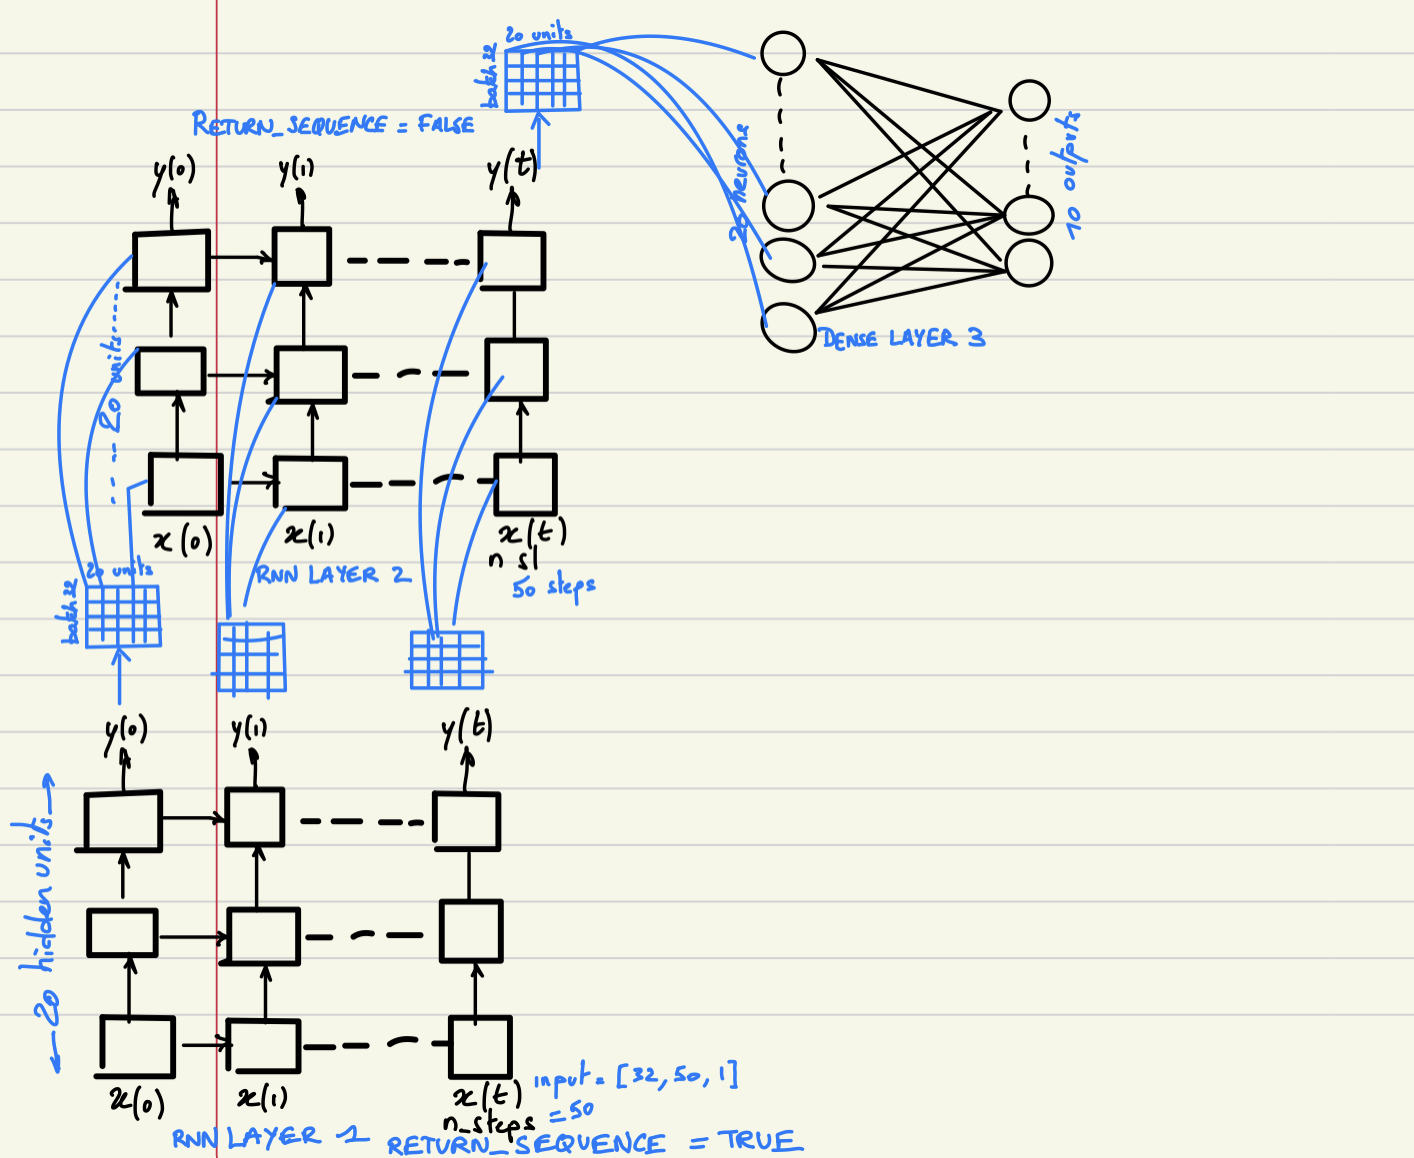

In [18]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", optimizer=optimizer)

In [19]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 23ms/step - loss: 0.0546 - val_loss: 0.0278
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0317 - val_loss: 0.0288
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0288 - val_loss: 0.0335
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0359 - val_loss: 0.0405
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0318 - val_loss: 0.0282
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0280 - val_loss: 0.0353
Epoch 7/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0336 - val_loss: 0.0307
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0265 - val_loss: 0.0297
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0316 - val_loss: 0.0252
Epoch 10/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0254 - val_lo

We get a validation loss that is much lower than other models. 

The output of all steps are useful upon training (MSE of all outputs), but only the output on the final step is useful for predicting, as we designed a sequence-to-vector architecture.

To make our model a sequence-to-sequence model, make return_sequence true for all layers and we must apply the output Dense to all time steps using 'TimeDistributed':

In [20]:
#model = keras.Sequential([
#    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
#    keras.layers.SimpleRNN(20, return_sequences=True), 
#    keras.layers.TimeDistributed(Dense(10))
#])